In this notebook, we will explore Gaussian Process Machine Learning model for the external Ligand set in ethanol dataset.

# GP Model for Nickel Catalyzed Borylation in EtOH

### Load libraries

In [1]:
%matplotlib inline
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import torch
import gpytorch

### Load Preprocessed Ethanol Dataset

In [2]:
dataset = pd.read_csv("./data/data_EtOH_Final.csv")
dataset.head()

,ArylHalide_CX_Lowdin,ArylHalide_C_Chem Shift,ArylHalide_C_Electrostatic,ArylHalide_C_Exposed Area,ArylHalide_C_Mulliken,ArylHalide_XY_Chem Shift_Max,ArylHalide_XY_Chem Shift_Min,ArylHalide_XY_Electrostatic_Max,ArylHalide_XY_Electrostatic_Min,ArylHalide_XY_Exposed Area_Avg,...,Kraken_vbur_vbur_max,Kraken_vbur_vbur_min,Kraken_vbur_vtot_boltz,Kraken_vmin_r_boltz,Kraken_vmin_vmin_boltz,Ligand,Ligand_inchi,Product_inchi,Solvent_inchi,Yield
0,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,50.731606,50.731606,351.19888,1.840787,-0.055960,A-paPhos,InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",87.13
1,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,80.673770,61.935337,479.46484,1.803143,-0.058457,CX-FBu,InChI=1S/C29H39P.BF4/c1-2-3-22-29(27-20-12-10-...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",6.37
2,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,107.755370,56.694310,386.44120,1.805810,-0.058387,CX-PCy,InChI=1S/C22H30NP/c1-4-11-19(12-5-1)23-18-10-1...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",71.75
3,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,117.597336,54.091050,618.03375,1.817123,-0.054418,Cy-BippyPhos,InChI=1S/C36H39N4P/c1-6-16-28(17-7-1)34-36(35(...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",64.52
4,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,111.484024,57.033180,402.37967,1.816461,-0.061351,Cy-JohnPhos,InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",80.44


In [3]:
dataset.shape

(779, 163)

In [4]:
#Twenty three unique Ligands here excluding MeO-KITPHOS due to the lack of Kraken parameters
dataset.Ligand.unique().tolist()

['A-paPhos',
 'CX-FBu',
 'CX-PCy',
 'Cy-BippyPhos',
 'Cy-JohnPhos',
 'Cy-PhenCar-Phos',
 'Cy-vBRIDP',
 'Kwong',
 'MePhos',
 'PCy3 HBF4',
 'Ph-DavePhos',
 'Ph-SPhos',
 'Ph-XPhos',
 'PMe3 HBF4',
 'PnBu3 HBF4',
 'P(o-Anis)3',
 'P(p-Anis)3',
 'P(p-F-Ph)3',
 'PPh2Cy',
 'PPh3',
 'PPhtBu2',
 'PXy3',
 'VPhos']

In [5]:
#load external ligand dataset in EtOH
ex_dataset = pd.read_csv("./data/external_ligand_data_EtOH.csv")
ex_dataset.head()

,ArylHalide_CX_Lowdin,ArylHalide_C_Chem Shift,ArylHalide_C_Electrostatic,ArylHalide_C_Exposed Area,ArylHalide_C_Mulliken,ArylHalide_XY_Chem Shift_Max,ArylHalide_XY_Chem Shift_Min,ArylHalide_XY_Electrostatic_Max,ArylHalide_XY_Electrostatic_Min,ArylHalide_XY_Exposed Area_Avg,...,Kraken_vbur_vbur_max,Kraken_vbur_vbur_min,Kraken_vbur_vtot_boltz,Kraken_vmin_r_boltz,Kraken_vmin_vmin_boltz,Ligand,Ligand_inchi,Product_inchi,Solvent_inchi,Yield
0,1.09,129.449,0.124,7.356,0.004,120.935,118.065,-0.177,-0.341,13.589,...,117.552360,56.790530,430.68256,1.797235,-0.062511,Cy-JohnPhos-OMe,InChI=1S/C25H33OP/c1-26-24-18-10-8-16-22(24)23...,InChI=1S/C8H7BO3/c10-9(11)7-1-2-8-6(5-7)3-4-12...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",80.58
1,1.09,129.449,0.124,7.356,0.004,120.935,118.065,-0.177,-0.341,13.589,...,124.748184,58.538240,497.10650,1.784157,-0.063670,CPhos,InChI=1S/C28H41N2P/c1-29(2)25-19-13-20-26(30(3...,InChI=1S/C8H7BO3/c10-9(11)7-1-2-8-6(5-7)3-4-12...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",67.06
2,1.09,129.449,0.124,7.356,0.004,120.935,118.065,-0.177,-0.341,13.589,...,109.966415,55.457000,415.06253,1.801754,-0.061979,CX-POMeCy,InChI=1S/C23H32NOP/c1-25-22-16-9-8-15-21(22)24...,InChI=1S/C8H7BO3/c10-9(11)7-1-2-8-6(5-7)3-4-12...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",78.86
3,1.09,129.449,0.124,7.356,0.004,120.935,118.065,-0.177,-0.341,13.589,...,49.582157,43.828636,151.64550,1.826696,-0.062157,PEt3,"InChI=1S/C6H15P/c1-4-7(5-2)6-3/h4-6H2,1-3H3",InChI=1S/C8H7BO3/c10-9(11)7-1-2-8-6(5-7)3-4-12...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",8.66
4,1.09,129.449,0.124,7.356,0.004,120.935,118.065,-0.177,-0.341,13.589,...,54.862930,51.901974,330.64270,1.833448,-0.054343,PPh2(o-Anis),InChI=1S/C19H17OP/c1-20-18-14-8-9-15-19(18)21(...,InChI=1S/C8H7BO3/c10-9(11)7-1-2-8-6(5-7)3-4-12...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",79.61


In [6]:
#12 new external ligands
ex_dataset.Ligand.unique().tolist()

['Cy-JohnPhos-OMe',
 'CPhos',
 'CX-POMeCy',
 'PEt3',
 'PPh2(o-Anis)',
 'RuPhos',
 'P(p-CF3-Ph)3',
 'CM-Phos',
 'PBn3',
 'CX-PInCy',
 'S-Phos',
 'PPhCy2']

In [7]:
#Training set
ML_data_traintest = dataset
ML_data_traintest2 = ML_data_traintest.drop(['Electrophile_inchi', 'Solvent_inchi', 'Ligand_inchi', 'Product_inchi', 'Electrophile', 'Ligand'], axis = 1)
print (ML_data_traintest2.shape)
ML_data_traintest2.head()

(779, 157)


,ArylHalide_CX_Lowdin,ArylHalide_C_Chem Shift,ArylHalide_C_Electrostatic,ArylHalide_C_Exposed Area,ArylHalide_C_Mulliken,ArylHalide_XY_Chem Shift_Max,ArylHalide_XY_Chem Shift_Min,ArylHalide_XY_Electrostatic_Max,ArylHalide_XY_Electrostatic_Min,ArylHalide_XY_Exposed Area_Avg,...,Kraken_vbur_qvtot_min_min,Kraken_vbur_qvtot_min_vburminconf,Kraken_vbur_ratio_vbur_vtot_boltz,Kraken_vbur_vbur_boltz,Kraken_vbur_vbur_max,Kraken_vbur_vbur_min,Kraken_vbur_vtot_boltz,Kraken_vmin_r_boltz,Kraken_vmin_vmin_boltz,Yield
0,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,59.829678,59.829678,0.144453,50.731606,50.731606,50.731606,351.19888,1.840787,-0.055960,87.13
1,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,47.895260,67.167030,0.134809,64.636100,80.673770,61.935337,479.46484,1.803143,-0.058457,6.37
2,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,36.894516,75.417816,0.211005,81.541550,107.755370,56.694310,386.44120,1.805810,-0.058387,71.75
3,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,45.164505,77.044235,0.160584,99.246600,117.597336,54.091050,618.03375,1.817123,-0.054418,64.52
4,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,44.561430,72.197180,0.212085,85.339290,111.484024,57.033180,402.37967,1.816461,-0.061351,80.44


### Normalize Training set to unit scale with min-max function

In [8]:
# Response target are all adjusted between 0~1
y_train = ML_data_traintest2['Yield']/100

#Normalize the input predictors to unit scale
Data_X = ML_data_traintest2.drop(columns=['Yield'])

#Transform the training set
sc = MinMaxScaler()
X_train = sc.fit_transform(Data_X)

#convert to torch from numpy
train_x = torch.from_numpy(np.array(X_train)).float()
train_y = torch.from_numpy(np.array(y_train)).float().view(-1)

In [9]:
#Gaussian Process Model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        if len(train_x) > 0:
            dims = len(train_x[0])
        else:
            dims = 0
        kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=dims)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(kernel)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [10]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [11]:
model.likelihood.noise_covar.register_constraint("raw_noise", gpytorch.constraints.GreaterThan(1e-5))

In [12]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
            {'params': model.parameters()},], 
            lr=0.05)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f  noise: %.3f' % (i + 1, training_iter, loss.item(), model.likelihood.noise.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.032  noise: 0.693
Iter 2/50 - Loss: 1.007  noise: 0.668
Iter 3/50 - Loss: 0.983  noise: 0.644
Iter 4/50 - Loss: 0.959  noise: 0.621
Iter 5/50 - Loss: 0.935  noise: 0.598
Iter 6/50 - Loss: 0.912  noise: 0.576
Iter 7/50 - Loss: 0.890  noise: 0.554
Iter 8/50 - Loss: 0.867  noise: 0.533
Iter 9/50 - Loss: 0.845  noise: 0.512
Iter 10/50 - Loss: 0.823  noise: 0.492
Iter 11/50 - Loss: 0.801  noise: 0.473
Iter 12/50 - Loss: 0.779  noise: 0.454
Iter 13/50 - Loss: 0.756  noise: 0.436
Iter 14/50 - Loss: 0.734  noise: 0.418
Iter 15/50 - Loss: 0.711  noise: 0.401
Iter 16/50 - Loss: 0.688  noise: 0.384
Iter 17/50 - Loss: 0.665  noise: 0.368
Iter 18/50 - Loss: 0.641  noise: 0.353
Iter 19/50 - Loss: 0.618  noise: 0.337
Iter 20/50 - Loss: 0.595  noise: 0.323
Iter 21/50 - Loss: 0.571  noise: 0.309
Iter 22/50 - Loss: 0.547  noise: 0.295
Iter 23/50 - Loss: 0.524  noise: 0.282
Iter 24/50 - Loss: 0.500  noise: 0.269
Iter 25/50 - Loss: 0.477  noise: 0.257
Iter 26/50 - Loss: 0.453  noise: 0

In [13]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
     train_pred = likelihood(model(train_x))

/opt/conda/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [14]:
#Check Top 50 Features by Lengthscale
ls = pd.Series(model.covar_module.base_kernel.lengthscale.detach().numpy()[0], 
               index=Data_X.columns.values, 
               name='l').sort_values()
ls.head(50)

ArylHalide_XY_Mulliken_Min                 1.906284
ArylHalide_XY_Natural_Min                  2.002632
ArylHalide_XY_Electrostatic_Min            2.032264
ArylHalide_XY_Chem Shift_Min               2.042483
ArylHalide_C_Exposed Area                  2.056830
ArylHalide_C_Chem Shift                    2.096512
ArylHalide_C_Electrostatic                 2.112947
ArylHalide_CX_Lowdin                       2.119690
ArylHalide_XY_Mulliken_Bond_Avg            2.147062
ArylHalide_XY_Mulliken_Bond_Min            2.168982
ArylHalide_XY_Length_Max                   2.174193
ArylHalide_XY_Exposed Area_Avg             2.181494
ArylHalide_XY_Lowdin_Avg                   2.188781
ArylHalide_XY_Lowdin_Min                   2.199247
ArylHalide_X_Electrostatic                 2.225632
ArylHalide_XY_Exposed Area_Max             2.239818
ArylHalide_XY_Chem Shift_Max               2.244990
ArylHalide_XY_Length_Min                   2.246651
ArylHalide_XY_Lowdin_Max                   2.252871
ArylHalide_X

### External Ligand set Evaluation

In [15]:
ext_y=ex_dataset['Yield']/100
ext_X=ex_dataset.iloc[:, ex_dataset.columns.isin(Data_X.columns)]
X_ext_transformed = sc.transform(ext_X)
external_x = torch.from_numpy(np.array(X_ext_transformed)).float()
external_y = torch.from_numpy(np.array(ext_y)).float().view(-1)

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
     pred = likelihood(model(external_x))
     # Get upper and lower confidence bounds; Returns 2 standard deviations above and below the mean
     lower, upper = pred.confidence_region()

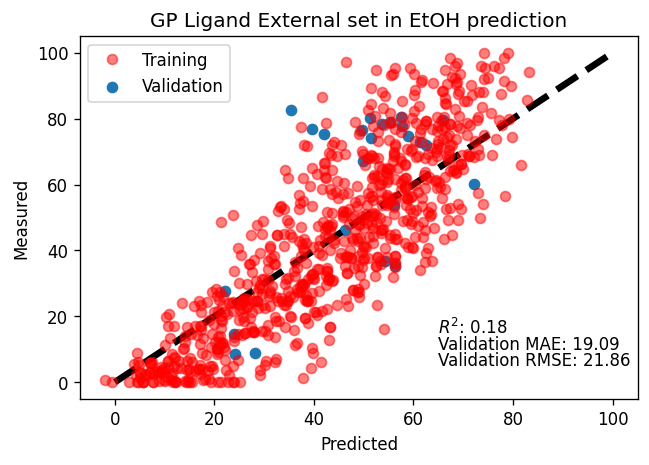

In [16]:
plt.rcParams['figure.dpi'] = 120
fig, ax = plt.subplots()
ax.scatter(pred.mean.numpy()*100,external_y*100,label="Validation")
ax.plot( [0,100],[0,100], 'k--', lw=4)
ax.plot(train_pred.mean.numpy()*100, y_train*100, "or", alpha=0.5, label="Training")
ax.text(65,15,r'$R^2$: {:0.2f}'.format(r2_score(external_y*100,pred.mean.numpy()*100)))
ax.text(65,10,'Validation MAE: {:0.2f}'.format(mean_absolute_error(external_y*100,pred.mean.numpy()*100)))
ax.text(65,5,'Validation RMSE: {:0.2f}'.format(np.sqrt(mean_squared_error(external_y*100,pred.mean.numpy()*100))))
ax.set_xlabel('Predicted')
ax.set_ylabel('Measured')
ax.set_title('GP Ligand External set in EtOH prediction')
plt.legend()
plt.show()

### Save results 

In [17]:
results=ex_dataset[['Electrophile','Ligand','Yield']]
results.reset_index(drop=True, inplace=True)
results['Pred_Yield']=pred.mean.numpy()*100
results.to_csv("results/GP_EtOH_Ligand_prediction.csv",index=False)

<ipython-input-17-83bd29ce56c2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Pred_Yield']=pred.mean.numpy()*100


In [18]:
results

,Electrophile,Ligand,Yield,Pred_Yield
0,5-Bromobenzofuran,Cy-JohnPhos-OMe,80.58,57.582508
1,5-Bromobenzofuran,CPhos,67.06,49.820675
2,5-Bromobenzofuran,CX-POMeCy,78.86,55.214291
3,5-Bromobenzofuran,PEt3,8.66,24.212421
4,5-Bromobenzofuran,PPh2(o-Anis),79.61,65.868408
5,5-Bromobenzofuran,RuPhos,75.21,41.993309
6,5-Bromobenzofuran,P(p-CF3-Ph)3,80.15,51.164021
7,5-Bromobenzofuran,CM-Phos,82.63,35.360878
8,5-Bromobenzofuran,PBn3,27.75,22.072153
9,5-Bromobenzofuran,CX-PInCy,77.80,57.682209


In [19]:
%load_ext watermark

In [20]:
%watermark --iversions

matplotlib: 3.3.3
seaborn   : 0.11.1
torch     : 1.10.1+cu113
pandas    : 1.2.0
numpy     : 1.19.2
gpytorch  : 1.6.0

